# Проект по классификации токсичных комментариев. TF-IDF

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности.

Цель постройть модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
!pip install catboost
!pip install transformers
!pip install spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 1.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
import re
import spacy
from tqdm import notebook
from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
import transformers
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

try:
    df = pd.read_csv(pth1)
except:
    df = pd.read_csv(pth2)

Избавимся от ненужного столбца, который копирует индексы

In [ ]:
df = df.drop('Unnamed: 0', axis=1)

### EDA

In [ ]:
df.text[:5]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
df[df.text.duplicated()].sum()

text     0.0
toxic    0.0
dtype: float64

In [ ]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Рассмотрим баланс классов, так как для обучения нам нужны обьекты как положительного, так и отрицательного класса

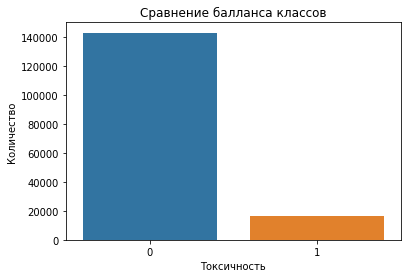

In [ ]:
sns.countplot(x=df['toxic']);
plt.title('Сравнение балланса классов');
plt.xlabel("Токсичность");
plt.ylabel("Количество");
plt.grid(False)

In [ ]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Классы несблансированы, но в нашей задаче это достаточно предсказуемо,  потому что обычно токсичных комментариев меньше

### Лемматизируем и очистим текст

Напишем функцию лемматизации и очистки текста

In [ ]:
corpus = df['text'].astype('str')

In [ ]:
nlp = spacy.load('en_core_web_sm')
regex = re.compile(r'[^a-zA-Z]')

def lemmatize_and_clear_text(text):
    doc = nlp(text)
    lem_text = [token.lemma_.lower() for token in doc if token.is_alpha]
    text_out = ' '.join(lem_text)
    text_out = regex.sub(' ', text_out)
    return text_out

In [ ]:
corpus_lemma = corpus.apply(lemmatize_and_clear_text)

Проверим

In [ ]:
print("Исходный текст:", corpus[0])
print("Лемматизированный текст:", corpus_lemma[0])

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Лемматизированный текст: explanation why the edit make under my username hardcore metallica fan be revert they be vandalism just closure on some gas after i vote at new york dolls fac and please do remove the template from the talk page since i retire


### Делим выборки

In [ ]:
df['text_lemma'] = corpus_lemma
features = df['text_lemma']
target = df['toxic']

In [ ]:
RANDOM_STATE = 42

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target,
                                                                            test_size=0.2, random_state=RANDOM_STATE)

### Векторизация корпусов

In [ ]:
tf_idf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english', min_df=3, max_df=0.9,
    strip_accents='unicode', use_idf=True, smooth_idf=True, sublinear_tf=True)
tf_idf_train = tf_idf.fit_transform(features_train)
tf_idf_test = tf_idf.transform(features_test)

In [ ]:
print("Размер матрицы:", tf_idf_train.shape, tf_idf_test.shape)

Размер матрицы: (127433, 36283) (31859, 36283)


## Обучение

### LogisticRegression

In [ ]:
cv = 5

In [ ]:
log_reg_model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

param_grid = {
}

grid_search = GridSearchCV(log_reg_model, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=10)
grid_search.fit(tf_idf_train, target_train)

log_reg_score = grid_search.best_score_
print(log_reg_score)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5; 1/1] END ........................................... total time=  33.9s
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END ........................................... total time=  28.9s
[CV 3/5; 1/1] START ............................................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5; 1/1] END ........................................... total time=  29.8s
[CV 4/5; 1/1] START ............................................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5; 1/1] END ........................................... total time=  32.0s
[CV 5/5; 1/1] START ............................................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5; 1/1] END ........................................... total time=  34.1s
0.7498105476559265


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### RandomForestClassifier

In [ ]:
model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
param_grid = {
'n_estimators': [10, 50, 100],
'max_depth': [3, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=10)
grid_search.fit(tf_idf_train, target_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=3, n_estimators=10................................
[CV 1/5; 1/9] END ..............max_depth=3, n_estimators=10; total time=   0.3s
[CV 2/5; 1/9] START max_depth=3, n_estimators=10................................
[CV 2/5; 1/9] END ..............max_depth=3, n_estimators=10; total time=   0.3s
[CV 3/5; 1/9] START max_depth=3, n_estimators=10................................
[CV 3/5; 1/9] END ..............max_depth=3, n_estimators=10; total time=   0.3s
[CV 4/5; 1/9] START max_depth=3, n_estimators=10................................
[CV 4/5; 1/9] END ..............max_depth=3, n_estimators=10; total time=   0.3s
[CV 5/5; 1/9] START max_depth=3, n_estimators=10................................
[CV 5/5; 1/9] END ..............max_depth=3, n_estimators=10; total time=   0.4s
[CV 1/5; 2/9] START max_depth=3, n_estimators=50................................
[CV 1/5; 2/9] END ..............max_depth=3, n_es

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='f1', verbose=10)

In [ ]:
forest_score = grid_search.best_score_
print(forest_score)

0.375350890383831


### CatBoostClassifier

Рассчитаем веса классов

In [ ]:
count_negative = (target_train == 0).sum()
count_positive = (target_train == 1).sum()
scale_pos_weight = count_negative / count_positive

In [ ]:
model = CatBoostClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE)

param_grid = {
    'depth': [3],
    'iterations': [200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=10)

grid_search.fit(tf_idf_train, target_train)

catboost_score = grid_search.best_score_

print("F1 Score:", catboost_score)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START depth=3, iterations=200.....................................
Learning rate set to 0.324686
0:	learn: 0.6138840	total: 746ms	remaining: 2m 28s
1:	learn: 0.5822147	total: 1.38s	remaining: 2m 16s
2:	learn: 0.5567401	total: 2.03s	remaining: 2m 13s
3:	learn: 0.5397490	total: 2.69s	remaining: 2m 11s
4:	learn: 0.5290329	total: 3.34s	remaining: 2m 10s
5:	learn: 0.5181888	total: 3.99s	remaining: 2m 8s
6:	learn: 0.5063415	total: 4.62s	remaining: 2m 7s
7:	learn: 0.4929421	total: 5.26s	remaining: 2m 6s
8:	learn: 0.4858585	total: 5.9s	remaining: 2m 5s
9:	learn: 0.4807926	total: 6.52s	remaining: 2m 3s
10:	learn: 0.4756025	total: 7.18s	remaining: 2m 3s
11:	learn: 0.4646971	total: 7.79s	remaining: 2m 2s
12:	learn: 0.4584428	total: 8.41s	remaining: 2m
13:	learn: 0.4539681	total: 9.01s	remaining: 1m 59s
14:	learn: 0.4496637	total: 9.62s	remaining: 1m 58s
15:	learn: 0.4443755	total: 10.2s	remaining: 1m 57s
16:	learn: 0.4412497

### Сравнение

In [ ]:
pd.DataFrame({'f1_score': [catboost_score, forest_score, log_reg_score]},
             index=['CatBoost', 'RandomForest', 'LogisticRegression']).round(3)

,f1_score
CatBoost,0.742
RandomForest,0.375
LogisticRegression,0.750


Как мы видим наилучшей метрикой обладают модель LogisticRegression, следовательно ее и будем использовать дальше.

### Тест

Для увеличения метрики f1 мы можем обучить нашу лучшую модель на кроссвалидации на всем обучающем наборе данных

In [ ]:
log_reg_model.fit(tf_idf_train, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:
prediction = log_reg_model.predict(tf_idf_test)
print(round(f1_score(target_test, prediction), 3))

0.75


### DummyRegressor

In [ ]:
dum_prediction = pd.Series(1, index=target_test)

print(f1_score(target_test, dum_prediction))

0.18446546614998857


Как мы видим, модель которая помечает все строки токсичными, имеет точность всего лишь 0.18

## Выводы

Задачей проекта было разработать прототип модели машинного обучения, который мог бы предсказывать токсичность комментариев. В ходе работы были выполнены следующие шаги:
- Подготовка данных. В процессе подготовки данных были выполнены операции, такие как чтение и изучение данных, лемматизация, очистка и подготовка выборок для обучения модели.
- Анализ:
    - В данных имеется явный дисбаланс, устранили его с помощью встроенных методов весов в моделях машинного обучения.
- Данные были векторизированы.
- Перед обучением были разделены выборки в соотношении 1 к 5.
- Были обучены и протестированны три модели на кроссвалидации CatBoost, LogisticRegression и RandomForest.
- Самой удачной для нашей задачи является модель LogisticRegression c F1 = 0.75, что полностью удовлетворяет условиям задачи.